## **Argentina heatwaves**

In [2]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *

### **Pre-processing**

#### **Construct mask for region of interest**

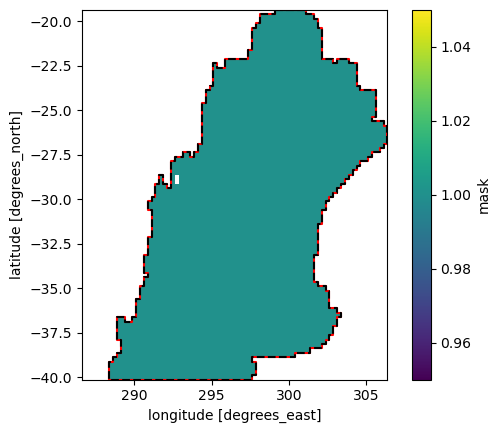

In [14]:
from xrspatial.experimental import polygonize
from shapely.geometry import Polygon

# load ERA5 geopotential data
gp = xr.open_dataset("../90_data/era5_geopotential.nc").squeeze(drop = True).z

# mask off Argentina only
rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(gp.longitude, gp.latitude).sel(region = [9,156]).sum("region")

# find areas within Argentina with geopotential < 20000
rm = rm.where(rm).where(gp < 20000).dropna("latitude", "all").dropna("longitude", "all").sel(latitude = slice(None, -40))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## CONVERT TO POLYGON

# define affine transform to correct coordinates
res = 0.25
transform = np.array([res,0,rm.longitude.min().values - res/2,0,-res,rm.latitude.max().values + res/2])

# convert xarray data to polygon, remove any interior holes
rm_poly = polygonize(rm, mask = rm == 1, return_type = "geopandas", transform = transform).set_crs(epsg = "4326")
rm_poly["geometry"] = rm_poly.geometry.apply(lambda p: Polygon(list(p.exterior.coords)))

# extract points from polygon
rm_px = rm_poly["geometry"].apply(lambda p: list(p.exterior.coords)).explode().apply(pd.Series).rename(columns=({0:"x", 1:"y"}))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# SAVE

# save as shapefile, csv & regionmask
rm_poly.to_file("study-region_AR-PY")
rm_px.to_csv("study-region_AR-PY.txt", sep = " ", index = False)
# rm.to_netcdf("study-region_AR-PY.nc")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CONFIRM

# check that these are all capturing the same area
rm.plot()
ax = plt.gcf().axes[0]
rm_poly.boundary.plot(ax = ax, color = "red")
ax.plot(rm_px.x, rm_px.y, color = "k", ls = "--")

#### **ERA5**

In [4]:
# era5 hourly to daily maximum in degC
era5 = xr.open_dataset("data/adaptor.mars.internal-1670941002.8189573-22169-17-a055d329-231c-4c6a-95b3-7fe35064ddb5.nc").sortby("time").mx2t
era5 = convert_units_to(era5, "degC").resample(time = "D").max().mean("expver")

# time series of latest data
sf = gpd.read_file("study-region_AR-PY")
rm = regionmask.mask_3D_geopandas(sf, era5.longitude, era5.latitude).squeeze(drop = True)
era5_2022 = era5.where(rm).dropna("latitude", "all").dropna("longitude", "all").mean(["latitude", "longitude"])

# concatenate latest data with regional download from climate explorer
era5_hist = xr.open_dataset("data/iera5_tmax_daily_e_mask11_5lan_su.nc").tmax.dropna("time", "any")

era5_hist.to_netcdf("data/era5_AR-PY_daily.nc")

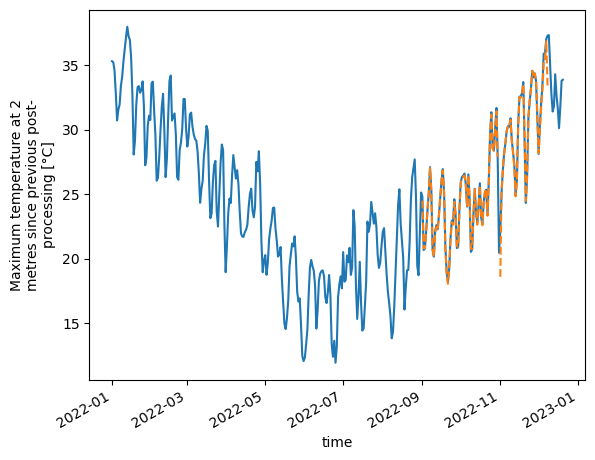

In [3]:
# visual check that regionmask has worked & that my data is equivalent to that downloaded from cx
era5_hist.sel(time = "2022").plot()
era5_2022.plot(ls = "--")

<GeoAxesSubplot:title={'center':'time = 2022-12-08'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

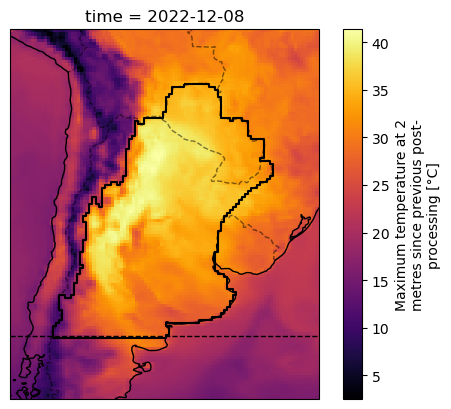

In [14]:
fig, axs = plt.subplots(dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
era5.sel(time = "2022-12-08").plot(ax = axs, cmap = "inferno")
axs.coastlines()
axs.add_feature(cartopy.feature.BORDERS, alpha = 0.5, ls = "--")

axs.axhline(-40, ls = "--", color = "k", lw = 1)

sf.to_crs(axs.projection).boundary.plot(ax = axs, color = "k", lw = 1.5)

#### **CPC**

In [29]:
sf = gpd.read_file("study-region_AR-PY")

cpc = []
for fnm in sorted(glob.glob("../03_cpc/tmax/*.nc")):
    
    tmax = xr.open_dataset(fnm).tmax.sel(lon = slice(285,310), lat = slice(-18,-42)).load()
    rm = regionmask.mask_3D_geopandas(sf, tmax.lon, tmax.lat).squeeze(drop = True)
    
    tmax = tmax.where(rm).dropna("lat", "all").dropna("lon", "all")
    cpc.append(tmax)

cpc_ts = xr.concat(cpc, "time").mean(["lat", "lon"])
cpc_ts.to_netcdf("data/cpc_AR-PY_daily.nc")

#### **Comparison of ERA5 & CPC**

In [30]:
ndays = 7

cpc_ndaymean = xr.open_dataset("data/cpc_AR-PY_daily.nc").tmax.rolling(time = ndays, center = False).mean()
era5_ndaymean = xr.open_dataset("data/era5_AR-PY_daily.nc").tmax.rolling(time = ndays, center = False).mean()

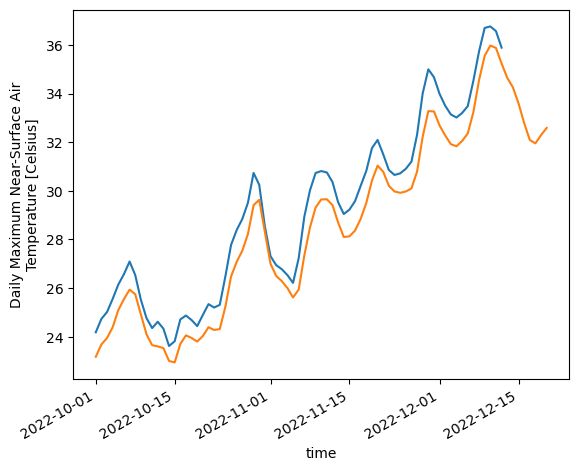

In [31]:
cpc_ndaymean.sel(time = slice("2022-10", None)).plot()
era5_ndaymean.sel(time = slice("2022-10", None)).plot()

Text(0.5, 1.0, 'Difference between CPC & ERA5 7-day maximum: ~1.2°C')

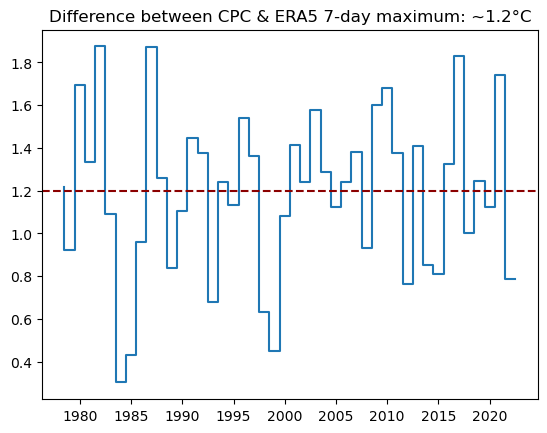

In [33]:
# difference between CPC & ERA5 maxima was used to compute provisional ERA5 value prior to observing the event
cpc_ann = cpc_ndaymean.resample(time = "AS-JUL").max()
era5_ann = era5_ndaymean.resample(time = "AS-JUL").max()

plt.step(cpc_ann.time, cpc_ann - era5_ann)
plt.axhline((cpc_ann - era5_ann).sel(time = slice(None, "2021")).mean(), color = "darkred", ls = "--")

plt.title("Difference between CPC & ERA5 "+str(ndays)+"-day maximum: ~"+str((cpc_ann - era5_ann).sel(time = slice(None, "2021")).mean().values.round(2))+"°C")

### **Time series of annual maxima**

In [34]:
# compute annual maxima of n-day rolling mean
def nday_max(da, n = 7):
    
    da_max = da.rolling(time = n, center = False).mean().resample(time = "AS-JUL").max()
    da_max = da_max.assign_coords(time = da_max.time.dt.year)
    
    return da_max

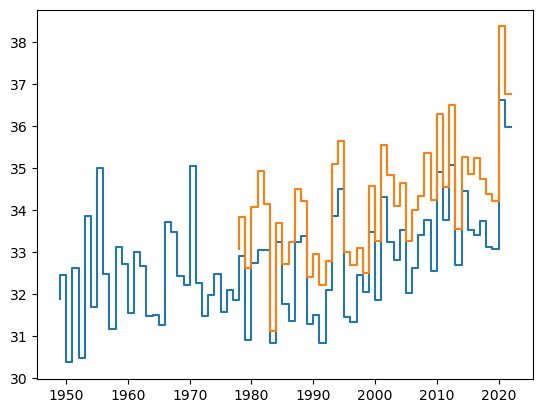

In [35]:
era5 = xr.open_dataset("data/era5_AR-PY_daily.nc").tmax
cpc = xr.open_dataset("data/cpc_AR-PY_daily.nc").tmax

era5_7daymax = nday_max(era5, 7)
cpc_7daymax = nday_max(cpc, 7)

plt.step(era5_7daymax.time,era5_7daymax)
plt.step(cpc_7daymax.time,cpc_7daymax)

#### **Time series for climate explorer**

In [39]:
csv_fnm = "ts/AR-PY_tasmax-7day_ERA5.dat"

# create extra header lines for upload to Climate Explorer
str1 = "# contact :: ERA5 max temperatures Argentina/Paraguay heatwave 2022, c.barnes22@imperial.ac.uk"
str2 = "# temperature [degC] 7-day max tmax Argentina/Paraguay at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
head = "# year tmax"

! echo "$str1 " > $csv_fnm
! echo "$str2" >> $csv_fnm
! echo "$head" >> $csv_fnm

nday_max(era5, 7).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

In [40]:
csv_fnm = re.sub("ERA5", "CPC", csv_fnm); str1 = re.sub("ERA5", "CPC", str1); str2 = re.sub("ERA5", "CPC", str2)

! echo "$str1 " > $csv_fnm
! echo "$str2" >> $csv_fnm
! echo "$head" >> $csv_fnm

cpc_7daymax.to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

#### **When do annual maxima occur?**

In [99]:
era5 = xr.open_dataset("data/era5_AR-PY_daily.nc").tmax.rolling(time = 7, center = False).mean()

In [103]:
era5_7daymax = era5.resample(time = "AS-JUL").max()
plt.step(era5_7daymax.time, era5_7daymax)

In [108]:
era5.sel(time = slice("1971-07-01", "1972-06-30")).idxmax()

<xarray.DataArray 'time' ()>
array('1971-12-30T00:00:00.000000000', dtype='datetime64[ns]')
Attributes:
    long_name:  Daily Maximum Near-Surface Air Temperature
    units:      Celsius

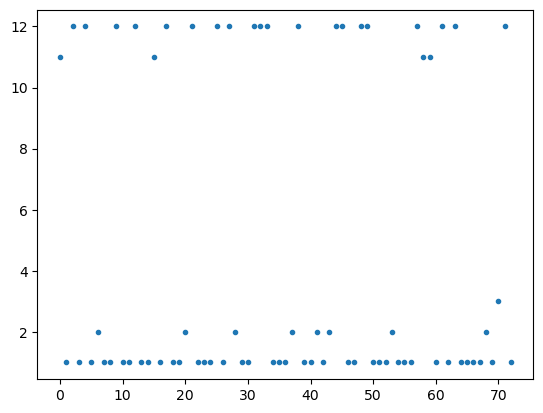

In [99]:
# mostly December & January
plt.plot([era5.sel(time = str(y)).idxmax().dt.month.values for y in set(era5.time.dt.year.values)],ls = "", marker = ".")

---
### **Map of event**

In [129]:
era5_2022 = xr.open_dataset("data/era5_2022-12.nc").sortby("time").mx2t.mean("expver")
era5_2022 = convert_units_to(era5_2022, "degC").resample(time = "D").max().sel(time = slice("2022-12-04", "2022-12-10")).mean("time")
era5_2022.to_netcdf("era5_event.nc")

In [138]:
# quick function to create event map
def event_map():
    
    ds = xr.open_dataset("era5_event.nc").mx2t
    sf = gpd.read_file("study-region_AR-PY").to_crs(cartopy.crs.PlateCarree())
    
    fig, ax = plt.subplots(ncols = 1, dpi = 100, figsize = (6,5), subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
    cbar_kw = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.07, "shrink" : 0.85, "label" : "Maximum temperature (°C)"}
    
    ds.plot(ax = ax, cmap = "inferno", cbar_kwargs = cbar_kw)
    
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", color = "k", alpha = 0.5)
    sf.boundary.plot(ax = ax, color = "k", lw = 1.5)
    
    ax.set_title("")
    ax.xlabels_top = False
    ax.ylabels_left = False
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left", "bottom"], xlocs = [-70,-65,-60,-55], alpha=0.1)
    
    return fig, ax

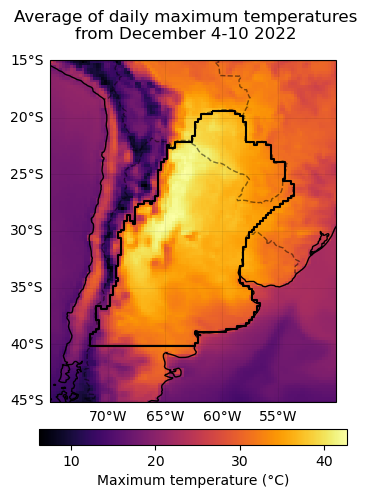

In [139]:
fig, axs = event_map()

plt.suptitle("Average of daily maximum temperatures\nfrom December 4-10 2022")
plt.savefig("event-definition_era5_7daymax.png")

In [ ]:
# CPC event map

cpc = xr.open_dataset("../03_cpc/tmax/tmax.2022.nc").sel(time = slice("2022-07-01", None), lat = slice(-18,-45), lon = slice(360-73,360-52)).tmax

sf = gpd.read_file("study-region_AR-PY").to_crs(cartopy.crs.PlateCarree())
rm = regionmask.mask_3D_geopandas(sf, cpc.lon, cpc.lat).squeeze(drop = True)

# rolling 7-day mean
cpc_7day = cpc.rolling(time = 7, center = False).mean()
hottest_7day = cpc_7day.sel(time = slice("2022-07-01", None)).where(rm).mean(["lat", "lon"]).idxmax().values
print(hottest_7day)

fig, ax = plt.subplots(ncols = 1, dpi = 100, figsize = (5.5,5), subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
cbar_kw = {"location" : "bottom", "fraction" : 0.05, "pad" : 0.07, "label" : "Maximum temperature (°C)"}

cpc_7day.sel(time = hottest_7day).plot(ax = ax, cmap = "inferno", cbar_kwargs = cbar_kw)

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, ls = "--", color = "k", alpha = 0.5)

sf.boundary.plot(ax = ax, color = "k", lw = 1.5)

ax.plot(*get_latlon("Buenos Aires").values(), marker = "o", mec = "k", color = "cornflowerblue")

ax.set_title("Average of daily maximum temperatures\nfrom December 4-10 2022 (CPC)")

ax.xlabels_top = False
ax.ylabels_left = False
ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left", "bottom"], xlocs = [-70,-65,-60,-55], alpha=0.1)

plt.savefig("event-definition_cpc_7daymax.png")

---
### **Station data**

In [341]:
# load all files and combine into a single DataFrame (December data for selected stations saved in separate DataFrame)
station_obs = []
for fnm in [fnm for fnm in sorted(glob.glob("data/stations/*.txt")) if not "dic2022" in fnm]:

    df = pd.read_csv(fnm, sep = "\t", index_col = "fecha")[["tmax"]]
    
    fnm_dec = re.sub(".txt", "-dic2022.txt", fnm)
    if len(glob.glob(fnm_dec)) > 0:
        df = pd.concat([df, pd.read_csv(fnm_dec, sep = "\t", index_col = "fecha")[["tmax"]]])
        
    df = df.dropna(axis = 0, how = "any").rename(columns = {"tmax" : int(re.sub(".txt", "", fnm.split("/")[-1]))})
    
    station_obs.append(df)
    
station_obs = reduce(lambda  left, right: pd.merge(left,right,left_index = True, right_index = True, how = 'outer'), station_obs)
station_obs.index = pd.to_datetime(station_obs.index)
station_obs.to_csv("data/stations.csv")

#### **Selecting stations to request extra data**

In [424]:
# load station obs
station_obs = pd.read_csv("data/stations.csv", index_col = "fecha")
station_obs.columns = [int(x) for x in station_obs.columns]

# load station locations
station_px = pd.read_csv("data/station_details.csv", index_col = ["omm_id"])

# add % available data
station_px = pd.merge(station_px, pd.DataFrame(station_obs.count(axis = 0) / len(station_obs), columns = ["prop_all"]),
                      left_index = True, right_index = True, how = "outer")

# add date of most recent observation
last_obs = {int(c) : station_obs[c].dropna(how = "any").index.max() for c in station_obs.columns}
station_px = pd.merge(station_px, pd.DataFrame.from_dict(last_obs, orient = "index", columns = ["last_obs"]),
                      left_index = True, right_index = True, how = "outer")

# remove stations without latest data
station_px = station_px.loc[station_px.last_obs >= "2022-11-30"]

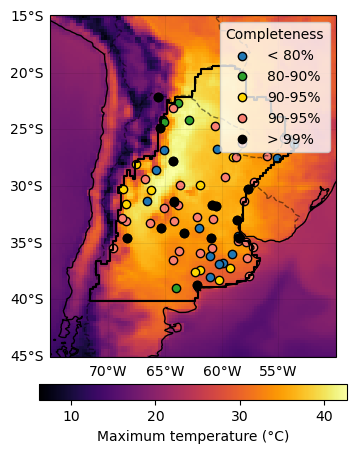

In [425]:
fig, ax = event_map()
ax.scatter(station_px.loc[station_px.prop_all < 0.8].lon_dec, station_px.loc[station_px.prop_all < 0.8].lat_dec, edgecolor = "k", label = "< 80%")

ax.scatter(station_px.loc[(station_px.prop_all >= 0.8) & (station_px.prop_all <= 0.9)].lon_dec, 
           station_px.loc[(station_px.prop_all >= 0.8) & (station_px.prop_all <= 0.9)].lat_dec, color = "tab:green", edgecolor = "k", label = "80-90%")

ax.scatter(station_px.loc[(station_px.prop_all >= 0.9) & (station_px.prop_all <= 0.95)].lon_dec, 
           station_px.loc[(station_px.prop_all >= 0.9) & (station_px.prop_all <= 0.95)].lat_dec, color = "gold", edgecolor = "k", label = "90-95%")

ax.scatter(station_px.loc[(station_px.prop_all >= 0.95)].lon_dec, 
           station_px.loc[(station_px.prop_all >= 0.95)].lat_dec, color = "salmon", edgecolor = "k", label = "90-95%")

ax.scatter(station_px.loc[(station_px.prop_all >= 0.99)].lon_dec, 
           station_px.loc[(station_px.prop_all >= 0.99)].lat_dec, color = "k", edgecolor = "k", label = "> 99%")

plt.legend(title = "Completeness")

# 45 stations with more than 95% data, 16 with more than 99% data. Start with those 16.

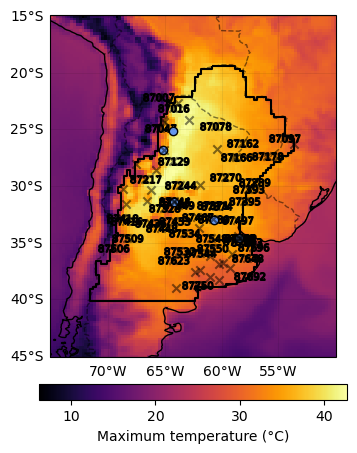

In [427]:
stn_99 = station_px.loc[station_px.prop_all > 0.95]

fig, ax = event_map()

for i in range(len(stn_99)):
    stn = stn_99.iloc[i]
    plt.scatter(stn.lon_dec, stn.lat_dec, marker = "$"+str(stn.name)+"$", color = "k", s = 500)
    
[ax.plot(*get_latlon(city).values(), marker = "o", mec = "k", color = "cornflowerblue") for city in ["Buenos Aires", "Cordoba, AR", "Rosario, AR", "San Miguel de Tucumán", "Salta"]]

ax.scatter(station_px.lon_dec, station_px.lat_dec, marker = "x", alpha = 0.5, color = "k", zorder = 99)

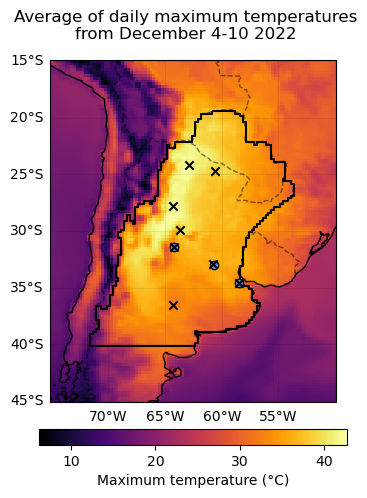

In [430]:
include = [87078, 87129, 87585, 87345, 87244, 87623, 87480, 87065]

fig, ax = event_map()

# Buenos Aires, Cordoba, Rosario: all cities with population > 1m in the 2010 census
[ax.plot(*get_latlon(city).values(), marker = "o", mec = "k", color = "cornflowerblue") for city in ["Cordoba, AR", "Rosario, AR", "Buenos Aires"]]

ax.scatter(station_px.loc[include].lon_dec, station_px.loc[include].lat_dec, marker = "x", color = "k", zorder = 99)

plt.suptitle("Average of daily maximum temperatures\nfrom December 4-10 2022")

plt.savefig("suggested-stations.png")

#### **Time series for climate explorer**

In [605]:
# load station observations & get 7-day average of daily maxima
include = [str(x) for x in [87078, 87129, 87585, 87345, 87244, 87623, 87480, 87065]]
df = pd.read_csv("data/stations.csv", index_col = "fecha", parse_dates = True)[include].rolling(7, center = False).mean().resample("AS-JUL").max()
df.index = df.index.year

# load station details
station_px = pd.read_csv("data/station_details.csv", index_col = ["omm_id"]).loc[[int(x) for x in include]]

for stn in include:
    
    csv_fnm = "ts/AR-PY_tasmax-7day_station_"+stn+".dat"
    
    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: station "+stn+" max temperatures Argentina/Paraguay heatwave 2022, c.barnes22@imperial.ac.uk"
    str2 = "# temperature [degC] 7-day max tmax Argentina/Paraguay at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    str3 = "# [name, lon, lat, elev] = "+str(station_px.loc[int(stn)].to_list())
    head = "# year tmax"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$str3" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    dfs = df[[stn]].dropna(how = "any")
    dfs.to_csv(csv_fnm, sep = " ", mode = "a", header = False)

#### **Comparison of stations with ERA5**

In [638]:
# load ERA5 7-day maxima
era5 = pd.read_csv("ts/AR-PY_tasmax-7day_ERA5.dat", skiprows = 3, sep = " ", header = None, index_col = 0, names = ["tmax"])
era5.index = [pd.to_datetime(str(y)+"-07-01") for y in era5.index]

# load station observations & get 7-day average of daily maxima
include = [str(x) for x in [87078, 87129, 87585, 87345, 87244, 87623, 87480, 87065]]
df = pd.read_csv("data/stations.csv", index_col = "fecha", parse_dates = True)[include].rolling(7, center = False).mean().resample("AS-JUL").max()

# load station details
station_px = pd.read_csv("data/station_details.csv", index_col = ["omm_id"]).loc[[int(x) for x in include]]

# load ERA5 gridded maxima as closest proxy to station data
era_map = decode_times(xr.open_dataset("data/era5_tmax_daily_extended_-73--52E_-45--18N_su.62f4b5a82fde776a4c64f0ca33646aa0.info_-1_max_30_7v.nc", decode_times = False)).max_tmax
era_map = era_map.assign_coords(time = [pd.to_datetime(str(y)+"-07-01") for y in era_map.time.dt.year.values])

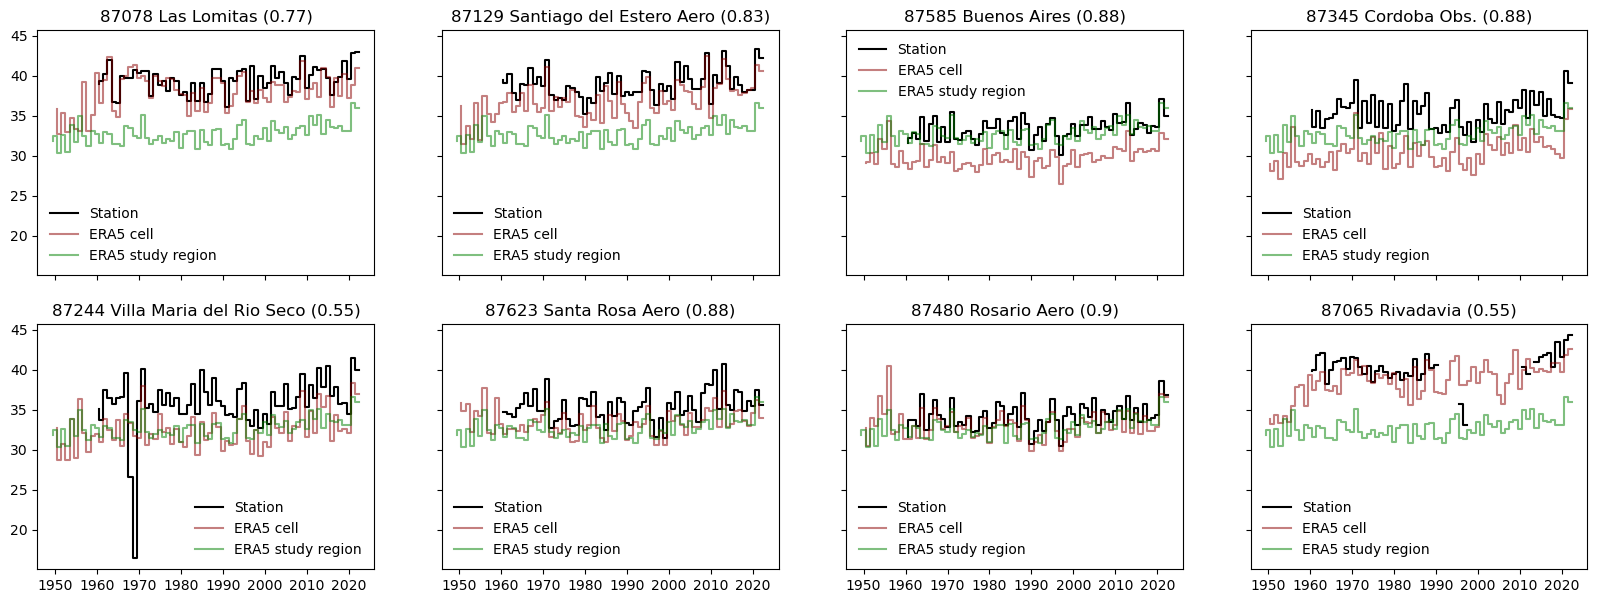

In [639]:
fig, axs = plt.subplots(ncols = 4, nrows = 2, dpi = 100, figsize = (20,7), sharex = True, sharey = True)

for stn in include:
    
    i = include.index(stn)
    ax = plt.gcf().axes[i]
    
    # station data
    ax.step(df.index, df[stn], color = "k", label = "Station")
    
    # add ERA5 nearest-neighbour point
    era5_cell = nearest_px(*station_px.loc[int(stn)][["lon_dec", "lat_dec"]],era_map, xcoord = "lon", ycoord = "lat")
    ax.step([pd.to_datetime(str(y)+"-07-01") for y in era_map.time.dt.year.values], 
            era5_cell, color = "darkred", alpha = 0.5, label = "ERA5 cell")
    
    # ERA5 average over study region
    ax.step(era5.index, era5, color = "green", alpha = 0.5, label = "ERA5 study region")
    
    ts_corr = pd.merge(df[[stn]], era5_cell.to_dataframe(), how = "inner", left_index = True, right_index = True).corr()["max_tmax"][stn].round(2)
    
    ax.set_title(stn+" "+station_px.loc[int(stn)].nombre+" ("+str(ts_corr)+")")
    ax.legend(edgecolor = "w")

#### **Results of climate explorer trend analysis**